In [1]:
__author__ = 'xuanzee'
#guided by Codecademy

## Introduction
The goal is to analyze biodiversity data from the National Parks Service around various species observed in different national park locations.

This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis.

The project is guided by Codecademy, with ficitional data.

A few questions to answer:
- What is the distribution of conservation status for species?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which animal is most prevalent and what is their distribution amongst parks?

## Import Modules

In [2]:
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency

import string
from itertools import chain

import matplotlib.pyplot as plt

## Preview and Explore Data

In [3]:
df_species = pd.read_csv('species_info.csv')

In [4]:
df_species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [5]:
print(df_species['conservation_status'].unique())

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [6]:
print(len(df_species))

5824


In [7]:
print(df_species['scientific_name'].nunique())

5541


In [8]:
print(df_species['category'].nunique())

7


In [9]:
print(df_species['category'].unique())

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [10]:
df_species.groupby('category').size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

In [11]:
print(df_species['conservation_status'].isna().sum())

5633


In [12]:
df_species.groupby('conservation_status').size()

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64

In [13]:
df_observations = pd.read_csv('observations.csv')

In [14]:
df_observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [15]:
df_observations['park_name'].nunique()

4

In [16]:
print(df_observations['park_name'].unique())

['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [17]:
print(len(df_observations))

23296


In [18]:
df_observations['observations'].sum()

3314739

## Analysis

In [19]:
#Converting 'nan' to value in the species dataset.
df_species.fillna('No Intervention', inplace=True)

In [20]:
df_species.groupby('conservation_status').size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

### Conservation Status Distribution

In [21]:
conservationCat = df_species[df_species['conservation_status'] != 'No Intervention'] \
                    .groupby(['conservation_status', 'category'])['scientific_name'].count().unstack()

In [22]:
conservationCat

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


Comparing the number of species by category in the status of "In Recovery" and "Endangered", it seems that birds are bouncing back more than mammals.

Text(0, 0.5, 'Number of Species')

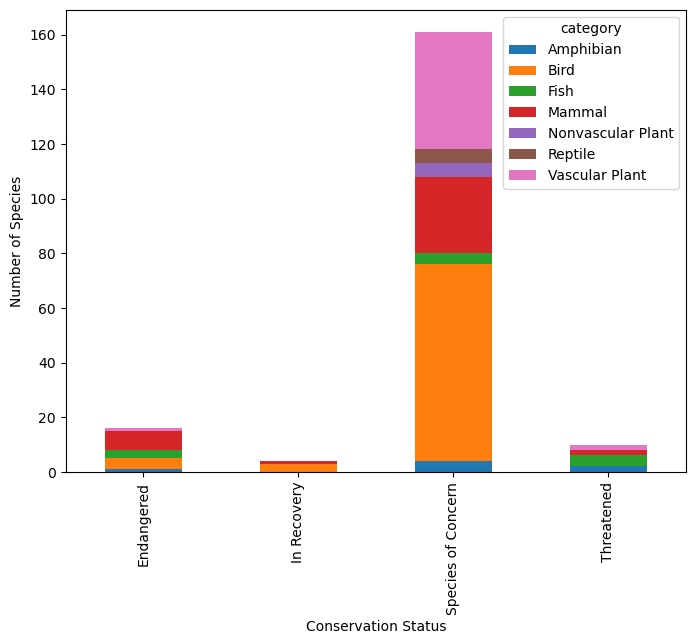

In [23]:
ax = conservationCat.plot(kind='bar', figsize=(8,6), stacked=True)
ax.set_xlabel('Conservation Status')
ax.set_ylabel('Number of Species')

### Likelihood to Be Endangered

In [24]:
df_species['is_protected'] = df_species['conservation_status'] != 'No Intervention'

In [25]:
cat_counts = df_species.groupby(['category', 'is_protected']).scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected', index='category', values='scientific_name')\
                        .reset_index()

In [26]:
cat_counts.columns = ['category', 'unprotected','protected']

In [27]:
cat_counts.sort_values(by='protected', ascending=False)

,category,unprotected,protected
1,Bird,413,75
6,Vascular Plant,4216,46
3,Mammal,146,30
2,Fish,115,11
0,Amphibian,72,7
4,Nonvascular Plant,328,5
5,Reptile,73,5


By absolute number, birds, mammals, and vascular plants have more species protected.

In [28]:
cat_counts['percent_protected'] = cat_counts['protected'] / \
                                    (cat_counts['unprotected'] + cat_counts['protected']) * 100

In [29]:
cat_counts.sort_values(by='percent_protected', ascending=False)

,category,unprotected,protected,percent_protected
3,Mammal,146,30,17.045455
1,Bird,413,75,15.368852
0,Amphibian,72,7,8.860759
2,Fish,115,11,8.730159
5,Reptile,73,5,6.410256
4,Nonvascular Plant,328,5,1.501502
6,Vascular Plant,4216,46,1.079305


By percentage, mammals and birds have more species protected.

### Statistical Significance

In [30]:
cont_mammal_bird = [[30, 146], [75, 413]]
chi2_contingency(cont_mammal_bird)

Chi2ContingencyResult(statistic=0.1617014831654557, pvalue=0.6875948096661336, dof=1, expected_freq=array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))

In [31]:
cont_mammal_amphibian = [[30, 146], [7, 72]]
chi2_contingency(cont_mammal_amphibian)

Chi2ContingencyResult(statistic=2.321746712946015, pvalue=0.12757669693198975, dof=1, expected_freq=array([[ 25.5372549, 150.4627451],
       [ 11.4627451,  67.5372549]]))

In [32]:
cont_mammal_fish = [[30, 146], [11, 115]]
chi2_contingency(cont_mammal_fish)

Chi2ContingencyResult(statistic=3.647651024981415, pvalue=0.0561483484489001, dof=1, expected_freq=array([[ 23.89403974, 152.10596026],
       [ 17.10596026, 108.89403974]]))

In [33]:
cont_mammal_reptile = [[30, 146], [5, 73]]
chi2_contingency(cont_mammal_reptile)

Chi2ContingencyResult(statistic=4.289183096203645, pvalue=0.03835559022969898, dof=1, expected_freq=array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))

In [34]:
cont_mammal_nonvas = [[30, 146], [5, 328]]
chi2_contingency(cont_mammal_nonvas)

Chi2ContingencyResult(statistic=41.0526001992972, pvalue=1.481868915759314e-10, dof=1, expected_freq=array([[ 12.1021611, 163.8978389],
       [ 22.8978389, 310.1021611]]))

In [35]:
cont_mammal_vas = [[30, 146], [46, 4216]]
chi2_contingency(cont_mammal_vas)

Chi2ContingencyResult(statistic=246.5870424874456, pvalue=1.4405067309854046e-55, dof=1, expected_freq=array([[3.01397026e+00, 1.72986030e+02],
       [7.29860297e+01, 4.18901397e+03]]))

When p-value is bigger than 0.05, there is no significant relationship between the two variables.
When testing the difference between mamals and reptiles, the p-value is smaller than 0.05, meaning mammals have a statistically significant higher rate of needing protection, compared to reptiles.

### Species in Parks

In [36]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [37]:
#list_common_names = df_species[(df_species.category != 'Nonvascular Plant') &
#                              (df_species.category != 'Vascular Plant')]\
#                    .common_names.apply(remove_punctuations).str.split().tolist()

list_common_names = df_species[df_species.category == 'Mammal']\
                    .common_names.apply(remove_punctuations).str.split().tolist()
#Only looking at mammals.

In [38]:
list_common_names[:5]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk']]

In [39]:
dedup_rows = []

for item in list_common_names:
    item = list(dict.fromkeys(item))
    dedup_rows.append(item)

In [40]:
dedup_rows[:5]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk']]

In [41]:
list_collapsed = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in dedup_rows))
list_collapsed[:5]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison']

In [42]:
words_counted = []

for i in list_collapsed:
    x = list_collapsed.count(i)
    words_counted.append((i,x))

In [43]:
pd.DataFrame(set(words_counted), columns=['Word', 'Count']).sort_values('Count', ascending=False).head(10)

,Word,Count
187,Bat,23
194,Shrew,18
146,Myotis,17
43,Mouse,16
120,Chipmunk,13
61,American,12
45,Squirrel,12
89,Eastern,11
135,Vole,11
185,Mountain,10


In [44]:
df_species['is_bat'] = df_species.common_names.str.contains(r'\bBat\b', regex=True)

In [45]:
df_species.head()

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False


In [46]:
df_species[df_species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


In [47]:
df_bat_obs = df_observations.merge(df_species[df_species.is_bat])

In [48]:
df_bat_obs

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


In [49]:
df_bat_obs.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


In [50]:
df_bat_obs_by_park = df_bat_obs.groupby(['park_name', 'is_protected']).observations.sum().reset_index()

In [51]:
df_bat_obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


Among the four parks, all except for Great Smoky Mountains National Park have more sightings for protected bats.

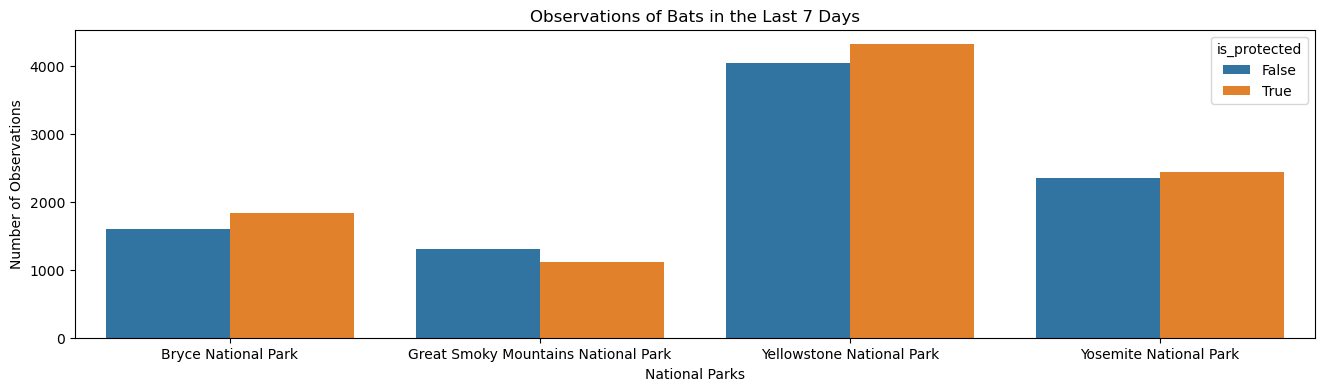

In [52]:
plt.figure(figsize=(16, 4))

sns.barplot(data=df_bat_obs_by_park, x='park_name', y='observations', hue='is_protected')

plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats in the Last 7 Days')
plt.show()

## Conclusions
The project was able to make visualizations and inferences about the various species in four of the National Parks that comprised this dataset.
Questions posed in the beginning were answered:
- What is the distribution of conservation status for species?
    - The majority of species were not part of conservations.(5633 out of 5824 requires no intervention.)
- Are certain types of species more likely to be endangered?
    - Mammals and birds had the highest percentage of being in protection.
- Are the differences between species and their conservation status significant?
    - Compared to reptiles, mammals have a statistically significant higher rate of needing protection.
- Which animal is most prevalent and what is their distribution amongst parks?
    - The study found that bats occurred the most number of times and they were most likely to be found in Yellowstone National Park.

## Further Research
1. Data of long time periods can be added to observe change over time.
2. Area of the parks can be added for more objective comparisons, as parks with larger areas could have more animal sightings and greater biodiversity as a result.
3. Geo-related information can be added so that spatial distribution can be observed. Climate-related information can also be brought in for similar considerations.